# Winter Data
Coastal Endurance - Oregon Offshore Cabled Deep Profiler Mooring

05 Dec 2015 00:00:00 to 06 Dec 2015 00:00:00 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import requests
import datetime

In [2]:
data = pd.read_csv("coastal_endurance_OFCDPM.csv")
data.head()

,obs,conductivity_millisiemens,conductivity_millisiemens_qc_executed,conductivity_millisiemens_qc_results,density,density_qc_executed,density_qc_results,deployment,dpc_ctd_seawater_conductivity,dpc_ctd_seawater_conductivity_qc_executed,...,preferred_timestamp,pressure,pressure_qc_executed,pressure_qc_results,raw_time_microseconds,raw_time_seconds,temp,temp_qc_executed,temp_qc_results,time
0,"('0',)",33.117401,1,0,1029.647494,29,29,2,3.31174,29,...,internal_timestamp,575.739990,29,29,977114,1450656067,5.1561,29,29,3.659645e+09
1,"('1',)",33.122501,1,0,1029.638947,29,29,2,3.31225,29,...,internal_timestamp,574.270020,29,29,972069,1450656078,5.1636,29,29,3.659645e+09
2,"('2',)",33.123299,1,0,1029.630912,29,29,2,3.31233,29,...,internal_timestamp,572.650024,29,29,977844,1450656089,5.1657,29,29,3.659645e+09
3,"('3',)",33.119598,1,0,1029.623473,29,29,2,3.31196,29,...,internal_timestamp,570.719971,29,29,984443,1450656100,5.1614,29,29,3.659645e+09
4,"('4',)",33.130001,1,0,1029.609999,29,29,2,3.31300,29,...,internal_timestamp,568.909973,29,29,979511,1450656111,5.1778,29,29,3.659645e+09


In [3]:
data.shape

(3347, 30)

In [4]:
#Defining parameters
ABDP_time = data.ingestion_timestamp
pres = data.pressure #same as depth as dbar is one to one to meters
sal = data.practical_salinity
T = data.temp

C:\Users\ctaing\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([736704.78462847, 736704.78463426, 736704.78464005, 736704.78464583,
        736704.78465162]), <a list of 5 Text xticklabel objects>)

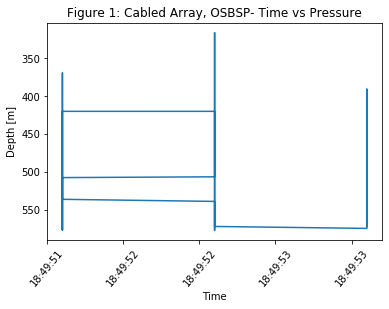

In [5]:
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()
#defines ntp_timezone and disregarding 70 yr offset

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

time7=[]
for i in range(len(ABDP_time)):
    time7.append(ntp_seconds_to_datetime(ABDP_time[i]))
    
plt.plot(time7,pres)
plt.gca().invert_yaxis() #Code to reverse depth
plt.xlabel('Time')
plt.ylabel('Depth [m]')
plt.title('Figure 1: Cabled Array, OSBSP- Time vs Pressure')
plt.xticks(rotation=50)


In [6]:
#Using data referenced from Matthew on 1/29/2020
def total_dives(pres):
    minimum_depth =max(pres)
    maximum_depth = False
    divecount = 0
    
    for i in range(0,len(pres)):
        if(pres[i]>0.95*minimum_depth and not maximum_depth):
            maximum_depth = True
        
        if(pres[i]<0.95*minimum_depth and maximum_depth):
            maximum_depth = False
            divecount +=1
    return divecount

print("Total dives within 24 hours of Oregon Offshore Cabled Deep Profiler Mooring is = ",total_dives(pres))

Total dives within 24 hours of Oregon Offshore Cabled Deep Profiler Mooring is =  12


In [7]:
#Defining speed of sound
c =1449.2+4.6*(T)-0.055*(T)**2+0.00029*T**3+(1.34-.01*T)*(sal-35)+0.016*pres
c_max = max(c)
print("Maximum speed of sound is ", c_max, "m/s")


Maximum speed of sound is  1482.9060882782496 m/s


Text(0.5, 1.0, 'Figure 2: Coastal Endurance, OFCDPM - Pressure (dbar) vs SSP')

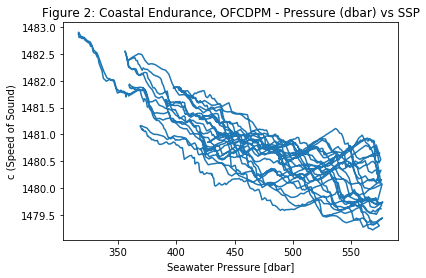

In [8]:
plt.plot(pres , c)
plt.xlabel('Seawater Pressure [dbar]')
plt.ylabel('c (Speed of Sound)')
plt.title('Figure 2: Coastal Endurance, OFCDPM - Pressure (dbar) vs SSP')


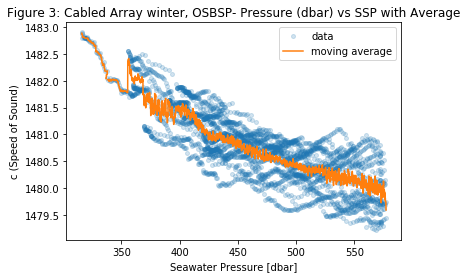

In [9]:
#define a moving average function
plt.plot(pres,c,'o',alpha=0.2,ms=4,label='data')
def moving_average(pres,c,step_size=0.1,bin_size=1):
    bin_centers = np.arange(np.min(pres),np.max(pres)-0.5*step_size,step_size)+0.5*step_size
    bin_avg = np.zeros(len(bin_centers))
    
    for index in range(0,len(bin_centers)):
        bin_center = bin_centers[index]
        items_in_bin = c[(pres>(bin_center-bin_size*0.5) ) & (pres<(bin_center+bin_size*0.5))]
        bin_avg[index] = np.mean(items_in_bin)
    return bin_centers,bin_avg

#plot the moving average
bins, average = moving_average(pres,c)
plt.plot(bins, average,label='moving average')
plt.xlabel('Seawater Pressure [dbar]')
plt.ylabel('c (Speed of Sound)')
plt.title('Figure 3: Cabled Array winter, OSBSP- Pressure (dbar) vs SSP with Average')
plt.legend()
plt.show()

#Please wait a moment, takes a lil while to publish for slower computers